In [1]:
import time
import jax
import jax.numpy as jnp
from utils.io import load_obj, create_triangle_arrays

In [2]:
#load object

square_path = "objects/square.obj"
sphere_path = "objects/sphere.obj"
cube_path = "objects/cube.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"
crawler = "objects/crawler.obj"
cornellbox = "objects/cornellbox.obj"


file_path = carrot

In [3]:
vertices, faces = load_obj(file_path)
triangles = create_triangle_arrays(vertices, faces)
triangles

{'vertex_1': Array([[-2.8973150e+00,  1.3289683e+01,  3.4134369e+00],
        [-2.3006700e-01,  1.0752763e+01,  7.9705000e-02],
        [ 1.0858000e-02,  1.0835635e+01, -2.0495400e-01],
        [ 3.9818701e-01,  1.3382749e+01,  1.9371000e-01],
        [-9.4076000e-02,  1.3273426e+01,  1.0305270e+00],
        [-1.1231000e-01,  1.4998567e+01,  5.8584201e-01],
        [-2.2138929e+00,  1.5225525e+01,  1.4856040e+00],
        [ 4.8523278e+00,  1.4013837e+01, -2.5449699e-01],
        [ 4.2591538e+00,  1.5081957e+01, -6.1435997e-01],
        [ 3.4277151e+00,  1.4238135e+01,  4.9385000e-02],
        [ 2.4769101e+00,  1.5459887e+01, -1.6992199e-01],
        [ 6.9417101e-01,  1.4996229e+01,  4.6680000e-01],
        [ 7.6956099e-01,  1.3632153e+01,  5.1836401e-01],
        [ 1.6574600e-01,  1.0752763e+01,  0.0000000e+00],
        [ 2.3400590e+00,  1.4351068e+01, -4.0018039e+00],
        [ 1.8073220e+00,  1.5251101e+01, -3.5135851e+00],
        [ 2.5343901e-01,  1.0752763e+01, -1.7044900e-01],
  

In [4]:
from accelerators.bvh import create_primitives, create_bvh_primitives, pack_primitives

# Create primitives (the geometry) and the BVH primitives (geometry with bounds and index).
primitives = create_primitives(triangles)

bvh_primitives = create_bvh_primitives(triangles)

In [5]:
from accelerators.bvh import build_bvh

# Choose a splitting method:
#  0 = Surface Area Heuristic (SAH)
#  1 = Middle split
#  2 = Equal counts (median)
split_method = 0

# Build the BVH. The build_bvh routine expects:
#   - primitives: list of primitives for intersection testing.
#   - bvh_primitives: list of helper objects (with .bounds and .prim_num).
#   - _start, _end: integer indices into the bvh_primitives list.
#   - ordered_prims: an initially empty list to be filled with primitives in BVH order.
#   - split_method: integer specifying the split method.
start_t = time.time()
nodes, ordered_prims = build_bvh(primitives, bvh_primitives, 0, len(bvh_primitives), [], split_method)
packed_prims = pack_primitives(ordered_prims)
end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 1.2455499172210693


In [6]:
from accelerators.bvh import flatten_bvh, pack_linear_bvh

# Flatten the BVH tree into a linear array for traversal.
# The root node is at index 0.
start_t = time.time()
linear_bvh_list = flatten_bvh(nodes, 0)
linear_bvh = pack_linear_bvh(linear_bvh_list)
end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.16092705726623535


In [7]:

print("BVH build complete.")
print("Number of BVH tree nodes:", len(nodes))
print("Number of linear BVH nodes:", len(linear_bvh_list))
print("Number of ordered primitives:", len(ordered_prims))

BVH build complete.
Number of BVH tree nodes: 267
Number of linear BVH nodes: 267
Number of ordered primitives: 152


In [8]:
# from tests.test_bvh import print_bvh_tree
#
# print_bvh_tree(nodes, 0)

In [9]:
# from tests.test_bvh import print_linear_bvh
#
# print_linear_bvh(linear_bvh_list)

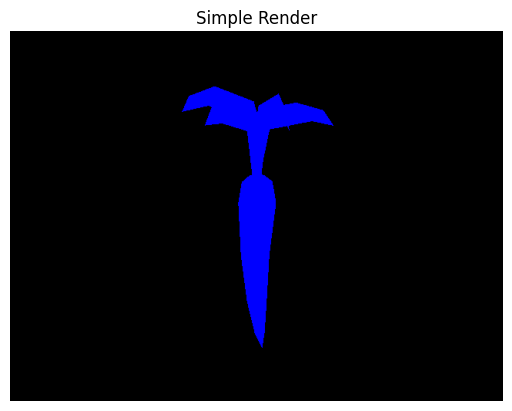

Elapsed (with compilation) = 21.774760007858276


In [10]:
from base.renderer import create_default_camera, render

# Create a default camera that frames the entire object.
width = 640
height = 480
fov = 45.0  # vertical field-of-view in degrees
camera = create_default_camera(triangles, width, height, fov)

start_t = time.time()

# Render the image.
image = render(linear_bvh, packed_prims, camera, batch_size=4096)





# Display the image using matplotlib.
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title("Simple Render")
plt.axis("off")
plt.show()

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

In [38]:
from primitives.triangle import intersect_triangle
from primitives.ray import Ray

# Define a simple triangle in the XY plane.
v0 = jnp.array([0.0, 0.0, 0.0])
v1 = jnp.array([1.0, 0.0, 0.0])
v2 = jnp.array([0.0, 1.0, 0.0])

# Define a ray that starts at (0.25, 0.25, -1) and points in the +Z direction.
ray_origin = jnp.array([0.25, 0.25, -1.0])
ray_direction = jnp.array([0.0, 0.0, 1.0])
ray = Ray(origin=ray_origin, direction=ray_direction)

t_max = 1e10  # some very large distance
hit, t = intersect_triangle(ray_origin, ray_direction, v0, v1, v2, t_max)

# Print the results.
print("Ray origin:", ray_origin)
print("Ray direction:", ray_direction)
print("Triangle vertices:", v0, v1, v2)
print("Intersection hit:", hit)
print("Intersection t:", t)

Ray origin: [ 0.25  0.25 -1.  ]
Ray direction: [0. 0. 1.]
Triangle vertices: [0. 0. 0.] [1. 0. 0.] [0. 1. 0.]
Intersection hit: True
Intersection t: 1.0
